<h1 align='center'>Face Gender Classification</h1>

# Import packages, libraries, Frameworks

In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import cv2
import datetime
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, BatchNormalization, Dropout, Flatten

from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [4]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Setup CUDA successful!")
except:
  print("Can not use CUDA")

Setup CUDA successful!


In [5]:
!nvidia-smi

Tue Aug 30 01:38:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    11W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Prepare dataset

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
%cd /content/drive/MyDrive/Face-Gender-Classification

/content/drive/MyDrive/Face-Gender-Classification


In [8]:
train_path = './data/train'
test_path  = './data/test'

In [9]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_ds = datagen.flow_from_directory(train_path,
	class_mode='binary', batch_size=64, target_size=(200, 200))
test_ds = datagen.flow_from_directory(test_path,
	class_mode='binary', batch_size=64, target_size=(200, 200))

Found 2000 images belonging to 2 classes.
Found 307 images belonging to 2 classes.


In [10]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Build Model

## Base Model

In [11]:
model = Sequential(name='base_model')
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# compile model
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "base_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 320000)            0         
                                                                 
 dense (Dense)               (None, 128)               40960128  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [12]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# history = model.fit(train_ds, validation_data=test_ds, epochs=100, callbacks=[callback])

csv_logger = CSVLogger('training.log', separator=',', append=False)
history = model.fit(train_ds, epochs=400, callbacks=[csv_logger])

Epoch 1/400
32/32 [==============================] - 16s 215ms/step - loss: 0.7890 - accuracy: 0.5840
Epoch 2/400
32/32 [==============================] - 7s 218ms/step - loss: 0.5938 - accuracy: 0.7060
Epoch 3/400
32/32 [==============================] - 7s 230ms/step - loss: 0.5915 - accuracy: 0.6845
Epoch 4/400
32/32 [==============================] - 7s 212ms/step - loss: 0.5317 - accuracy: 0.7350
Epoch 5/400
32/32 [==============================] - 7s 213ms/step - loss: 0.5324 - accuracy: 0.7265
Epoch 6/400
32/32 [==============================] - 7s 215ms/step - loss: 0.4894 - accuracy: 0.7705
Epoch 7/400
32/32 [==============================] - 8s 239ms/step - loss: 0.4954 - accuracy: 0.7630
Epoch 8/400
32/32 [==============================] - 7s 212ms/step - loss: 0.4605 - accuracy: 0.7950
Epoch 9/400
32/32 [==============================] - 7s 211ms/step - loss: 0.4670 - accuracy: 0.7825
Epoch 10/400
32/32 [==============================] - 7s 214ms/step - loss: 0.4491 - accur

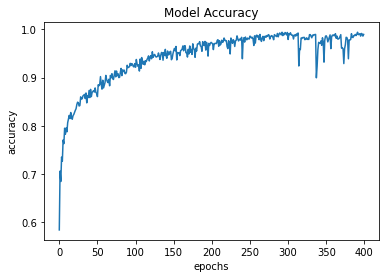

In [13]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
# plt.legend(['train', 'validation'], loc='upper left')
plt.show()

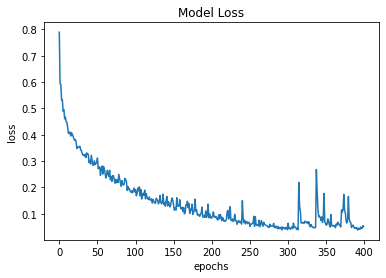

In [14]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
# plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss:     {:0.2f}".format(test_loss))
print("Test Accuracy: {:0.2f}".format(test_accuracy))

5/5 [==============================] - 2s 323ms/step - loss: 0.2303 - accuracy: 0.9153
Test Loss:     0.23
Test Accuracy: 0.92


In [16]:
model.save('Model_Base')
model.save_weights('Model_Base.h5')

In [21]:
img = cv2.imread('test.jpg')
img = cv2.resize(img, (200, 200))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = tf.expand_dims(img, axis=0)
model.predict(img)

array([[1.]], dtype=float32)